In [1]:
import sys
import os

### import necessary for jupyter
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

sys.path.insert(0, module_path)
from experiments.train_helper import *
from torch.utils.data import DataLoader
from common.utils import HDF5Dataset
from experiments.models_cnn import ResCNN, Res1DCNN
from experiments.models_fno import FNO1d_time, FNO2d
from equations.PDEs import KdV, KS
from notebooks.plot_helper import *

In [2]:
samples = (512, 128, 32)
saved_model = {}
#saved_model[512] = f'../models/FNO1d_time_KdV_samples512_augmentation1111_future20_time1132338.pt'
#saved_model[256] = f'../models/FNO1d_time_KdV_samples256_augmentation1111_future20_time1132338.pt'
#saved_model[128] = f'../models/FNO1d_time_KdV_samples128_augmentation1111_future20_time1132338.pt'
#saved_model[64] = f'../models/FNO1d_time_KdV_samples64_augmentation1111_future20_time1132338.pt'
#saved_model[32] = f'../models/FNO1d_time_KdV_samples32_augmentation1111_future20_time1132338.pt'
#saved_model[16] = f'../models/FNO1d_time_KdV_samples16_augmentation1111_future20_time114853.pt'
saved_model[512] = f'../models/FNO1d_time_KdV_samples512_augmentation0000_future20_time1132338.pt'
#saved_model[256] = f'../models/FNO1d_time_KdV_samples256_augmentation0000_future20_time1132338.pt'
saved_model[128] = f'../models/FNO1d_time_KdV_samples128_augmentation0000_future20_time1132338.pt'
#saved_model[64] = f'../models/FNO1d_time_KdV_samples64_augmentation0000_future20_time1132338.pt'
saved_model[32] = f'../models/FNO1d_time_KdV_samples32_augmentation0000_future20_time1132338.pt'
#saved_model[16] = f'../models/FNO1d_time_KdV_samples16_augmentation0000_future20_time1132338.pt'
test_dataset = f'../data/KdV_test.h5'
pde = KdV()

nt = 140
nx = 256
tmax = 40
xmax = 128

time_history = 20
time_future = 20
time_resolution = nt
# Max number of previous points solver can eat
reduced_time_resolution = time_resolution - time_history
# Number of future points to predict
max_start_time = reduced_time_resolution - time_future

In [3]:
data = HDF5Dataset(test_dataset, mode="test", nt=nt, nx=nx, shift="fourier")
data_loader = DataLoader(data, batch_size=16, shuffle=False, num_workers=4)

In [4]:
loaded_model = {}
for sample in samples:
    loaded_model[sample] = FNO1d_time(pde, time_history=time_history, time_future=time_future)
    loaded_model[sample].load_state_dict(torch.load(saved_model[sample]))

In [5]:
p = {}
for sample in samples:
    for (u, dx, dt) in data_loader:
        p[sample] = torch.Tensor()
        labels = torch.Tensor()
        for start in range(time_history, max_start_time+1, time_future):
            end_time = start + time_history
            target_end_time = end_time + time_future
            if start == time_history:
                data = u[:, start:end_time]
                data = data.permute(0, 2, 1)
            else:
                data = torch.cat([data, pred], -1)
                data = data[..., -time_history:]
            pred = loaded_model[sample](data, dx, dt)
            p[sample] = torch.cat((p[sample], pred), -1)
        labels = u[:, 2*time_history:]
        #p[sample] = torch.cat((labels.permute(0,2,1)[:,:,:time_history], p[sample]), -1)
        p[sample] = p[sample].permute(0,2,1)
        break

In [6]:
nr = 9

x = torch.Tensor()
points = torch.Tensor()
nx_all = 0

t = torch.linspace(0, tmax, nt-2*time_history)
nx_all += nx

for i, sample in enumerate(samples):
    x = torch.cat((x, xmax * (i) + torch.linspace(0, xmax, nx)), -1)
    nx_all += nx
    points = torch.cat((points, p[sample][nr]), -1)

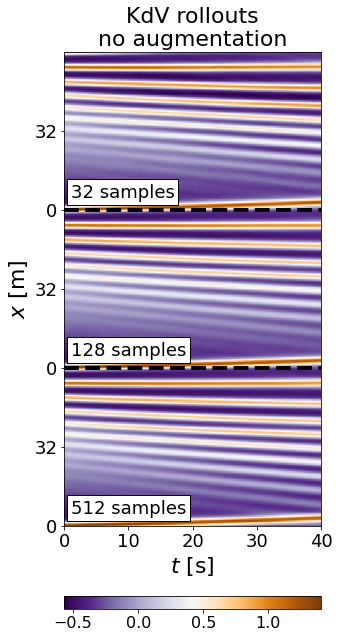

In [7]:
plot_trajectories(points.detach().numpy().T, nt, t, nx_all, x, samples, title=f'KdV rollouts\nno augmentation', pde=r"KdV0000", safe=True)

In [8]:
nr = 9

x = torch.Tensor()
errors = torch.Tensor()
nx_all = 0

t = torch.linspace(0, tmax, nt-2*time_history)

for i, sample in enumerate(samples):
    x = torch.cat((x, xmax * i + torch.linspace(0, xmax, nx)), -1)
    nx_all += nx
    mse = (labels[nr] - p[sample][nr]) ** 2 / torch.mean(labels[nr] ** 2, dim=-1, keepdim=True)
    errors = torch.cat((errors, mse), -1)

[  0.  64. 128. 192. 256. 320. 384.]


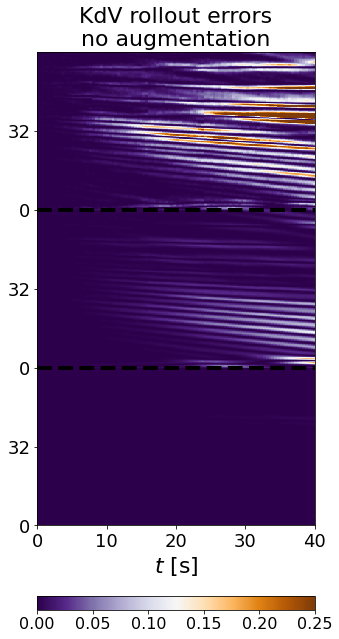

In [9]:
plot_trajectories(errors.detach().numpy().T, nt, t, nx_all, x, samples, title=f'KdV rollout errors\nno augmentation', pde=r"KdV0000", safe=True, errors=True)

In [10]:
samples = (512, 128, 32)
saved_model = {}
#saved_model[512] = f'../models/FNO1d_time_KS_samples512_augmentation111_future20_time117216.pt'
#saved_model[256] = f'../models/FNO1d_time_KS_samples256_augmentation111_future20_time117216.pt'
#saved_model[128] = f'../models/FNO1d_time_KS_samples256_augmentation111_future20_time117216.pt'
#saved_model[64] = f'../models/FNO1d_time_KS_samples64_augmentation111_future20_time117216.pt'
#saved_model[32] = f'../models/FNO1d_time_KS_samples64_augmentation111_future20_time117216.pt'
#saved_model[16] = f'../models/FNO1d_time_KS_samples16_augmentation111_future20_time117216.pt'
saved_model[512] = f'../models/FNO1d_time_KS_samples512_augmentation000_future20_time118750.pt'
#saved_model[256] = f'../models/FNO1d_time_KS_samples256_augmentation000_future20_time118750.pt'
saved_model[128] = f'../models/FNO1d_time_KS_samples128_augmentation000_future20_time118750.pt'
#saved_model[64] = f'../models/FNO1d_time_KS_samples64_augmentation000_future20_time118750.pt'
saved_model[32] = f'../models/FNO1d_time_KS_samples32_augmentation000_future20_time118750.pt'
#saved_model[16] = f'../models/FNO1d_time_KS_samples16_augmentation000_future20_time118750.pt'
test_dataset = f'../data/KS_test.h5'
pde = KS()

nt = 140
nx = 256
tmax = 20
xmax = 128

time_history = 20
time_future = 20
time_resolution = nt
# Max number of previous points solver can eat
reduced_time_resolution = time_resolution - time_history
# Number of future points to predict
max_start_time = reduced_time_resolution - time_future

In [11]:
data = HDF5Dataset(test_dataset, mode="test", nt=nt, nx=nx, shift="fourier")
data_loader = DataLoader(data, batch_size=16, shuffle=False, num_workers=4)
loaded_model = {}
for sample in samples:
    loaded_model[sample] = FNO1d_time(pde, time_history=time_history, time_future=time_future)
    loaded_model[sample].load_state_dict(torch.load(saved_model[sample]))

In [12]:
p = {}
for sample in samples:
    for (u, dx, dt) in data_loader:
        p[sample] = torch.Tensor()
        labels = torch.Tensor()
        for start in range(time_history, max_start_time+1, time_future):
            end_time = start + time_history
            target_end_time = end_time + time_future
            if start == time_history:
                data = u[:, start:end_time]
                data = data.permute(0, 2, 1)
            else:
                data = torch.cat([data, pred], -1)
                data = data[..., -time_history:]
            pred = loaded_model[sample](data, dx, dt)
            p[sample] = torch.cat((p[sample], pred), -1)
        labels = u[:, 2*time_history:]
        #p[sample] = torch.cat((labels.permute(0,2,1)[:,:,:time_history], p[sample]), -1)
        p[sample] = p[sample].permute(0,2,1)
        break

In [13]:
nr = 7

x = torch.Tensor()
points = torch.Tensor()
nx_all = 0

t = torch.linspace(0, tmax, nt-2*time_history)
nx_all += nx

for i, sample in enumerate(samples):
    x = torch.cat((x, xmax * (i) + torch.linspace(0, xmax, nx)), -1)
    nx_all += nx
    points = torch.cat((points, p[sample][nr]), -1)

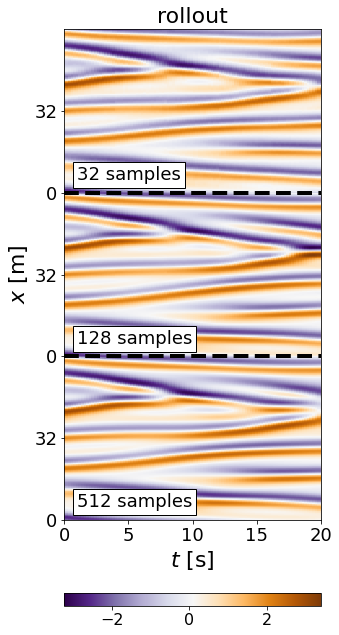

In [14]:
plot_trajectories(points.detach().numpy().T, nt, t, nx_all, x, samples, title=f'rollout', pde=r"KS000", safe=True)

In [15]:
nr = 7

x = torch.Tensor()
errors = torch.Tensor()
nx_all = 0

t = torch.linspace(0, tmax, nt-2*time_history)

for i, sample in enumerate(samples):
    x = torch.cat((x, xmax * i + torch.linspace(0, xmax, nx)), -1)
    nx_all += nx
    mse = (labels[nr] - p[sample][nr]) ** 2 / torch.mean(labels[nr] ** 2, dim=-1, keepdim=True)
    errors = torch.cat((errors, mse), -1)
# errors = errors*0.7

[  0.  64. 128. 192. 256. 320. 384.]


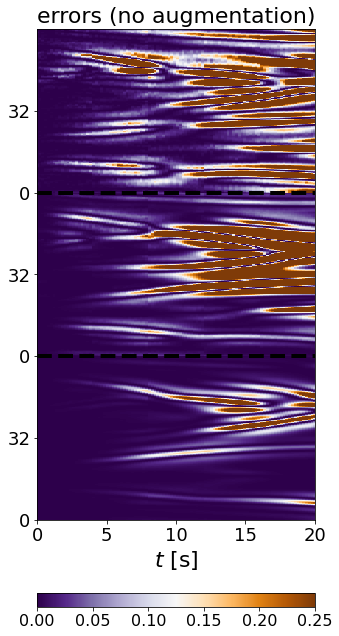

In [16]:
plot_trajectories(errors.detach().numpy().T, nt, t, nx_all, x, samples, title=f'errors (no augmentation)', pde=r"KS000", safe=True, errors=True)